## Libraries importation

In [1]:
# Please use these lines in every notebook you create

import os
import sys

# Get the current working directory
current_dir = os.getcwd()

# Get the parent directory of `maps` (which is `src`)
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))

# Add `src` to the module search path
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from global_variables import *
from python_scripts.miscellaneaous.data_processing import extract_data

In [2]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt

from python_scripts.ihm.plots import plot_graph
from python_scripts.neighbours_criteria.simple_criteria import distance_criterion, quadrant_criterion, angle_criterion
from python_scripts.neighbours_criteria.enhanced_criteria import distance_criterion_enhanced, quadrant_criterion_enhanced, angle_criterion_enhanced
from python_scripts.graphs.graphs_creation import delaunay_graph
from python_scripts.miscellaneaous.data_processing import extract_data
from python_scripts.city.city_utils import city_detection_enhanced, mean_distance_to_NN

In [3]:
# Path to where you want the outputs to be saved
out_directory = "../../out/"

## Database import and data extraction

We will focus only on the Normandie region, using Orange 4G base stations.

In [4]:
df_1pro_1techno = extract_data(pd.read_csv("../../database/data.csv", sep=";", decimal=","), provider=PROVIDER, techno=TECHNO, min_info=True)
df = pd.read_csv("../../database/data.csv", sep=";", decimal=",")
df = extract_data(df, min_info=True)
df.head()

/tmp/ipykernel_21763/2905695416.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1pro_1techno = extract_data(pd.read_csv("../../database/data.csv", sep=";", decimal=","), provider=PROVIDER, techno=TECHNO, min_info=True)
/tmp/ipykernel_21763/2905695416.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../../database/data.csv", sep=";", decimal=",")


,nom_op,x,y,latitude,longitude,nom_reg,nom_dep,nom_com,site_2g,site_3g,site_4g,site_5g
id_station_anfr,,,,,,,,,,,,
0632290204,Orange,739926.8,6542833.9,45.98406,3.51575,Auvergne-Rhône-Alpes,Puy-de-Dôme,Châteldon,1,1,1,0
0582290074,Orange,720558.3,6697009.6,47.37310,3.27243,Bourgogne-Franche-Comté,Nièvre,Menou,1,1,0,0
0802290015,Orange,687035.0,6985761.0,49.97028,2.81944,Hauts-de-France,Somme,Curlu,1,1,1,0
0642290151,Orange,422853.0,6249263.0,43.28861,-0.41389,Nouvelle-Aquitaine,Pyrénées-Atlantiques,Jurançon,1,1,1,0
0332290026,Orange,416932.0,6422196.0,44.84112,-0.58333,Nouvelle-Aquitaine,Gironde,Bordeaux,1,1,1,1


In [15]:
df_dep = pd.read_csv("../../database/data_popArea.csv", sep=";", decimal=",")

In [16]:
mean_distances = mean_distance_to_NN(df[['x', 'y']], n_neighbours=N_NEIGH)

In [17]:
city_detection = mean_distance_to_NN(df_1pro_1techno[['x', 'y']], n_neighbours=N_NEIGH)
df['countryside'] = city_detection
df['countryside'] = np.where((df['countryside'].values>3), 1, 0)

In [18]:
df.head()

,nom_op,x,y,latitude,longitude,nom_reg,nom_dep,nom_com,site_2g,site_3g,site_4g,site_5g,countryside
id_station_anfr,,,,,,,,,,,,,
0632290204,Orange,739926.8,6542833.9,45.98406,3.51575,Auvergne-Rhône-Alpes,Puy-de-Dôme,Châteldon,1,1,1,0,1
0582290074,Orange,720558.3,6697009.6,47.37310,3.27243,Bourgogne-Franche-Comté,Nièvre,Menou,1,1,0,0,0
0802290015,Orange,687035.0,6985761.0,49.97028,2.81944,Hauts-de-France,Somme,Curlu,1,1,1,0,1
0642290151,Orange,422853.0,6249263.0,43.28861,-0.41389,Nouvelle-Aquitaine,Pyrénées-Atlantiques,Jurançon,1,1,1,0,0
0332290026,Orange,416932.0,6422196.0,44.84112,-0.58333,Nouvelle-Aquitaine,Gironde,Bordeaux,1,1,1,1,0


In [19]:
df_meanDistance_dep = pd.DataFrame(columns=['nom_dep', 'city', 'countryside', 'total'])
# df_meanDistance_dep = pd.DataFrame(columns=['nom_dep', 'total'])

In [20]:
df_meanDistance_dep['nom_dep']=df_dep['nom_dep']

In [21]:
df_tmp_city = df.loc[((df['nom_dep']=='Haute-Savoie')) & (df['countryside']==0)]
coordsXY = df_tmp_city[['x', 'y']]

nbrs = NearestNeighbors(n_neighbors=10+1, metric='euclidean').fit(coordsXY)  # n_neighbors+1 because considering himself
distances, _ = nbrs.kneighbors(coordsXY)

new_dist = []
for d in distances:
    new_dist.append([x for x in d if x <= 6000])

maxi = 0
for d in distances:
    maxi = np.round(max(d), decimals=5) if(max(d)>maxi) else maxi
    # print(max(d)) if((max(d) > 4000) and (max(d) < 10000)) else _
# print('\n\n' + str(maxi))
maxi = 0
for d in new_dist:
    maxi = np.round(max(d), decimals=5) if(max(d)>maxi) else maxi
# print('\n\n' + str(maxi))



# mean_distances = np.mean(distances[:, 1:]/1000, axis=1)  # we exclude the first element (distance to ourself is 0)

In [22]:
def distance_to_NN(coordsXY: list, n_neighbours: int = 4, max_dist: int = np.inf) -> pd.Series:
    nbrs = NearestNeighbors(n_neighbors=n_neighbours+1, metric='euclidean').fit(coordsXY)  # n_neighbors+1 because considering himself
    distances, _ = nbrs.kneighbors(coordsXY)

    new_distances = []
    for row in distances:
        new_distances.append([x/1000 for x in row if((x/1000) <= max_dist)])
    
    mean_distances = [np.sum(row)/(len(row)-1) for row in new_distances]
    # np.mean(new_distances[:][1:], axis=1)  # we exclude the first element (distance to ourself is 0)

    return pd.Series(data=mean_distances, index=coordsXY.index)

In [23]:
for dep in df_dep['nom_dep']:
    n = 10
    df_tmp_city = df.loc[((df['nom_dep']==dep) & (df['countryside']==0))]
    # tmp_dist_city = distance_to_NN(df_tmp_city[['x', 'y']], n_neighbours=len(df_tmp_city)-1) if(len(df_tmp_city) > 1) else np.array([-1])
    tmp_dist_city = distance_to_NN(df_tmp_city[['x', 'y']], n_neighbours=n, max_dist=6) if(len(df_tmp_city) >= n) else np.array([-1])

    df_tmp_coun = df.loc[((df['nom_dep']==dep) & (df['countryside']==1))]
    # tmp_dist_coun = distance_to_NN(df_tmp_coun[['x', 'y']], n_neighbours=len(df_tmp_coun)-1) if(len(df_tmp_coun) > 1) else np.array([-1])
    tmp_dist_coun = distance_to_NN(df_tmp_coun[['x', 'y']], n_neighbours=n) if(len(df_tmp_coun) >= n) else np.array([-1])

    df_tmp_tota = df.loc[(df['nom_dep']==dep)]
    # tmp_dist_tota = distance_to_NN(df_tmp_tota[['x', 'y']], n_neighbours=len(df_tmp_tota)-1)
    tmp_dist_tota = distance_to_NN(df_tmp_tota[['x', 'y']], n_neighbours=n)

    df_meanDistance_dep.loc[df_meanDistance_dep['nom_dep']==dep, 'city'] = np.round(tmp_dist_city.mean(), decimals=5)
    df_meanDistance_dep.loc[df_meanDistance_dep['nom_dep']==dep, 'countryside'] = np.round(tmp_dist_coun.mean(), decimals=5)
    df_meanDistance_dep.loc[df_meanDistance_dep['nom_dep']==dep, 'total'] = np.round(tmp_dist_tota.mean(), decimals=5)
df_meanDistance_dep[['city','countryside','total']] = df_meanDistance_dep[['city','countryside','total']].astype(float)
# df_meanDistance_dep['total'] = df_meanDistance_dep['total'].astype(float)

/tmp/ipykernel_21763/1761526862.py:9: RuntimeWarning: invalid value encountered in scalar divide
  mean_distances = [np.sum(row)/(len(row)-1) for row in new_distances]
/tmp/ipykernel_21763/1761526862.py:9: RuntimeWarning: invalid value encountered in scalar divide
  mean_distances = [np.sum(row)/(len(row)-1) for row in new_distances]
/tmp/ipykernel_21763/1761526862.py:9: RuntimeWarning: invalid value encountered in scalar divide
  mean_distances = [np.sum(row)/(len(row)-1) for row in new_distances]
/tmp/ipykernel_21763/1761526862.py:9: RuntimeWarning: invalid value encountered in scalar divide
  mean_distances = [np.sum(row)/(len(row)-1) for row in new_distances]
/tmp/ipykernel_21763/1761526862.py:9: RuntimeWarning: invalid value encountered in scalar divide
  mean_distances = [np.sum(row)/(len(row)-1) for row in new_distances]
/tmp/ipykernel_21763/1761526862.py:9: RuntimeWarning: invalid value encountered in scalar divide
  mean_distances = [np.sum(row)/(len(row)-1) for row in new_dis

In [24]:
# for dep in df['nom_dep'].unique():
#     dep_distance_city = np.round(df.loc[((df['nom_dep']==dep) & (df['countryside']==0)), 'mean_dist'].mean(), decimals=5)
#     dep_distance_coun = np.round(df.loc[((df['nom_dep']==dep) & (df['countryside']==1)), 'mean_dist'].mean(), decimals=5)
#     dep_distance = np.round(df.loc[(df['nom_dep']==dep), 'mean_dist'].mean(), decimals=5)

#     df_new_row = pd.DataFrame(data=np.array([[dep,dep_distance_city,dep_distance_coun,dep_distance]]), columns=['nom_dep','city','countryside','total'])
#     df_meanDistance_dep = pd.concat([df_meanDistance_dep, df_new_row], ignore_index=True)
# df_meanDistance_dep[['city','countryside','total']] = df_meanDistance_dep[['city','countryside','total']].astype(float)

In [25]:
# for dep in df_dep['nom_dep']:
#     df_meanDistance_dep.loc[df_meanDistance_dep['nom_dep']==dep, 'Population'] = df_dep.loc[df_dep['nom_dep']==dep, 'Population'].iloc[0]
#     df_meanDistance_dep.loc[df_meanDistance_dep['nom_dep']==dep, 'Superficie [en km²]'] = df_dep.loc[df_dep['nom_dep']==dep, 'Superficie [en km²]'].iloc[0]
#     df_meanDistance_dep.loc[df_meanDistance_dep['nom_dep']==dep, 'Densite [hab. /km²]'] = df_dep.loc[df_dep['nom_dep']==dep, 'Densite [hab. /km²]'].iloc[0]
df_meanDistance_dep.insert(1, 'Densite [hab. /km²]', df_dep['Densite [hab. /km²]'])
df_meanDistance_dep.insert(1, 'Superficie [en km²]', df_dep['Superficie [en km²]'])
df_meanDistance_dep.insert(1, 'Population', df_dep['Population'])

df_meanDistance_dep[['Population', 'Superficie [en km²]', 'Densite [hab. /km²]']] = df_meanDistance_dep[['Population', 'Superficie [en km²]', 'Densite [hab. /km²]']].astype(int)

In [26]:
df_meanDistance_dep.head()

,nom_dep,Population,Superficie [en km²],Densite [hab. /km²],city,countryside,total
0,Gironde,1376000,10000,138,1.86804,8.28439,2.01688
1,Landes,327334,9243,35,2.65788,9.09107,2.99710
2,Dordogne,401500,9060,43,3.00582,7.87402,2.95922
3,Côte-d'Or,506755,8763,58,2.34981,8.00130,2.35620
4,Aveyron,271200,8735,31,2.95679,8.40126,3.01327


In [27]:
departments = list(np.unique(df["nom_dep"]))
nb_dep = len(departments)

df_proPerDep = pd.DataFrame({
    "nom_dep" : departments,
    "Total" : [int for i in range(nb_dep)]
})

for dep in departments: # number of sites per department per provider
    df_proPerDep.loc[df_proPerDep["nom_dep"]==dep, "Total"] = list(df["nom_dep"]).count(dep)

### ... Bidouillage

In [28]:
for dep in df_meanDistance_dep['nom_dep']:
    for where in ['city', 'countryside', 'total']:
        v = df_meanDistance_dep.loc[df_meanDistance_dep['nom_dep']==dep, where].astype(float).values
        tmp = (v - df_meanDistance_dep[where].min())/(df_meanDistance_dep[where].max()-df_meanDistance_dep[where].min())
        df_meanDistance_dep.loc[df_meanDistance_dep['nom_dep']==dep, f'normalized_{where}'] = np.round(tmp[0], decimals=5)
    # tmp = df_meanDistance_dep.loc[df_meanDistance_dep['nom_dep']==dep, 'city'].astype(float).values * (df_dep.loc[df_dep['nom_dep']==dep, 'Population'].astype(int).values) #(df_proPerDep.loc[df_proPerDep["nom_dep"]==dep, "Total"].astype(int).values * df_dep.loc[df_dep['nom_dep']==dep, 'Superficie [en km²]'].astype(int).values)
    # df_meanDistance_dep.loc[df_meanDistance_dep['nom_dep']==dep, 'normalized_city'] = np.round(tmp[0] / 100, decimals=5)
    # tmp = df_meanDistance_dep.loc[df_meanDistance_dep['nom_dep']==dep, 'total'].astype(float).values * (df_dep.loc[df_dep['nom_dep']==dep, 'Population'].astype(int).values) #(df_proPerDep.loc[df_proPerDep["nom_dep"]==dep, "Total"].astype(int).values * df_dep.loc[df_dep['nom_dep']==dep, 'Superficie [en km²]'].astype(int).values)
    # df_meanDistance_dep.loc[df_meanDistance_dep['nom_dep']==dep, 'normalized_total'] = np.round(tmp[0] / 100, decimals=5)

In [29]:
df_meanDistance_dep.sort_values(by=['total'])

,nom_dep,Population,Superficie [en km²],Densite [hab. /km²],city,countryside,total,normalized_city,normalized_countryside,normalized_total
95,Paris,2166200,105,20433,0.20258,-1.00000,0.20258,0.00000,0.00000,0.00000
94,Hauts-de-Seine,1517000,176,8619,0.41027,-1.00000,0.41027,0.07409,0.00000,0.05830
93,Seine-Saint-Denis,1485000,236,6292,0.47542,-1.00000,0.47542,0.09733,0.00000,0.07659
92,Val-de-Marne,1279000,245,5220,0.51970,-1.00000,0.51970,0.11313,0.00000,0.08902
87,Rhône,1667500,3249,513,1.02535,8.54248,1.04931,0.29351,0.81387,0.23769
...,...,...,...,...,...,...,...,...,...,...
13,Cher,314428,7235,43,2.31829,9.80524,3.37857,0.75474,0.92157,0.89154
59,Creuse,124470,5565,22,2.73880,9.17336,3.41222,0.90475,0.86768,0.90099
41,Orne,292337,6103,48,2.50168,10.22088,3.59688,0.82016,0.95702,0.95283
23,Indre,232000,6791,34,2.14606,10.15078,3.73929,0.69330,0.95104,0.99280


In [30]:
results = open(out_directory + "meanDistDeptClas.md", "w")

results.write(df_meanDistance_dep.sort_values(by=['city']).to_markdown(index=False))

results.close()

In [31]:
print("Superficie : " + str(np.corrcoef(df_meanDistance_dep['total'],df_meanDistance_dep['Superficie [en km²]'])[0,1]))
print("Population : " + str(np.corrcoef(df_meanDistance_dep['total'],df_meanDistance_dep['Population'])[0,1]))
print("Densite : " + str(np.corrcoef(df_meanDistance_dep['total'],df_meanDistance_dep['Densite [hab. /km²]'])[0,1]))

Superficie : 0.6144727205803495
Population : -0.8208622519156398
Densite : -0.5369752656452003


In [32]:
print("Superficie : " + str(np.corrcoef(df_meanDistance_dep['countryside'],df_meanDistance_dep['Superficie [en km²]'])[0,1]))
print("Population : " + str(np.corrcoef(df_meanDistance_dep['countryside'],df_meanDistance_dep['Population'])[0,1]))
print("Densite : " + str(np.corrcoef(df_meanDistance_dep['countryside'],df_meanDistance_dep['Densite [hab. /km²]'])[0,1]))

Superficie : 0.5053175575256332
Population : -0.46865568619733966
Densite : -0.7917853371788779


In [33]:
print("Superficie : " + str(np.corrcoef(df_meanDistance_dep['city'],df_meanDistance_dep['Superficie [en km²]'])[0,1]))
print("Population : " + str(np.corrcoef(df_meanDistance_dep['city'],df_meanDistance_dep['Population'])[0,1]))
print("Densite : " + str(np.corrcoef(df_meanDistance_dep['city'],df_meanDistance_dep['Densite [hab. /km²]'])[0,1]))

Superficie : 0.6263121577277645
Population : -0.8239535993523908
Densite : -0.5770948781384239


## Experimentation on only 4 departements
Mountains, Flat/Sea, Flat/City, Flat/Coutryside

In [34]:
df_tmp = df_meanDistance_dep.loc[(df_meanDistance_dep['nom_dep']=='Yvelines') | (df_meanDistance_dep['nom_dep']=='Loire-Atlantique') | (df_meanDistance_dep['nom_dep']=='Haute-Savoie') | (df_meanDistance_dep['nom_dep']=='Indre-et-Loire')]

In [35]:
def pretty_barPlot(df, x_col, y_col, **kwargs):
    plot_title = kwargs.get('save_as', None)
    
    sns.set_context('paper') # size of ticks labels
    sns.set_theme(style="whitegrid") # style of the backgroung
    g = sns.catplot(
        data=df,
        kind='bar',
        x=x_col,
        y=y_col,
    )
    g.tick_params(axis='x', rotation=15)
    plt.ylabel('distance [km]')
    
    if(plot_title):
        plt.savefig(out_directory + plot_title + ".png", dpi=100)

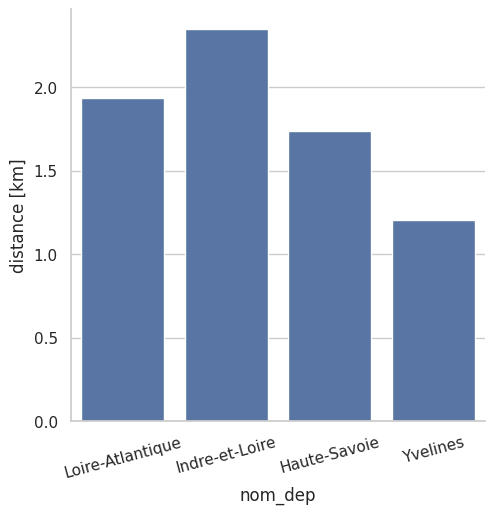

In [36]:
pretty_barPlot(df_tmp,'nom_dep','total')

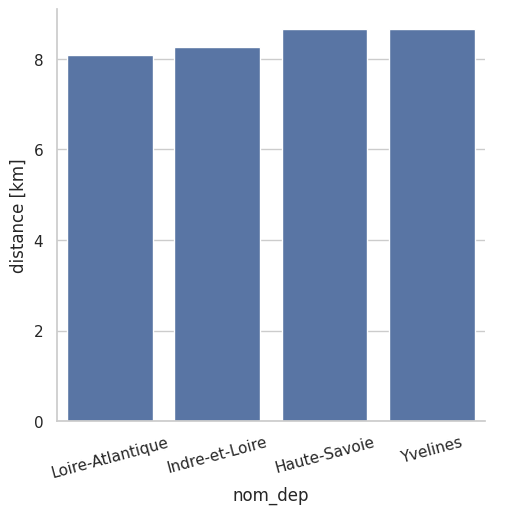

In [37]:
pretty_barPlot(df_tmp,'nom_dep','countryside')

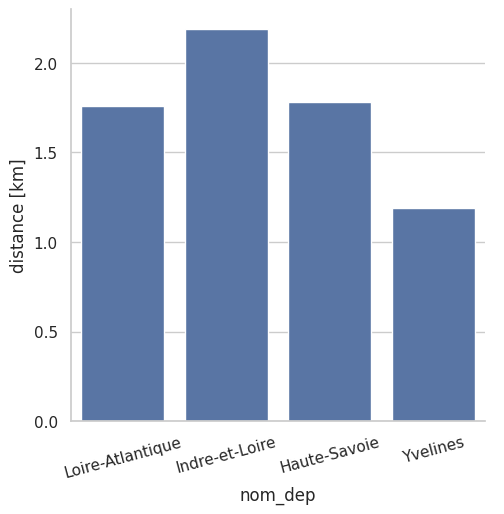

In [38]:
pretty_barPlot(df_tmp,'nom_dep','city')#'Population', 'Superficie [en km²]', 'Densite [hab. /km²]'